In [ ]:
from models import efanet
import torch
import timm
device = "cpu"
num_classes = 101
model_name = "efanet_base_patch16_224"
model = timm.create_model("efanet_base_patch16_224", pretrained=False, num_classes=num_classes).to(device)
checkpoint = torch.load('./efa_base.tar',map_location=device,weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
model.eval();

c:\Users\Yi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path: ./samples/1102160.jpg
Rank 1: Oysters (69) | Probability: 0.9014
Rank 2: Mussels (65) | Probability: 0.0020
Rank 3: Carrot cake (14) | Probability: 0.0017
Rank 4: French fries (40) | Probability: 0.0017
Rank 5: Cup cakes (29) | Probability: 0.0016


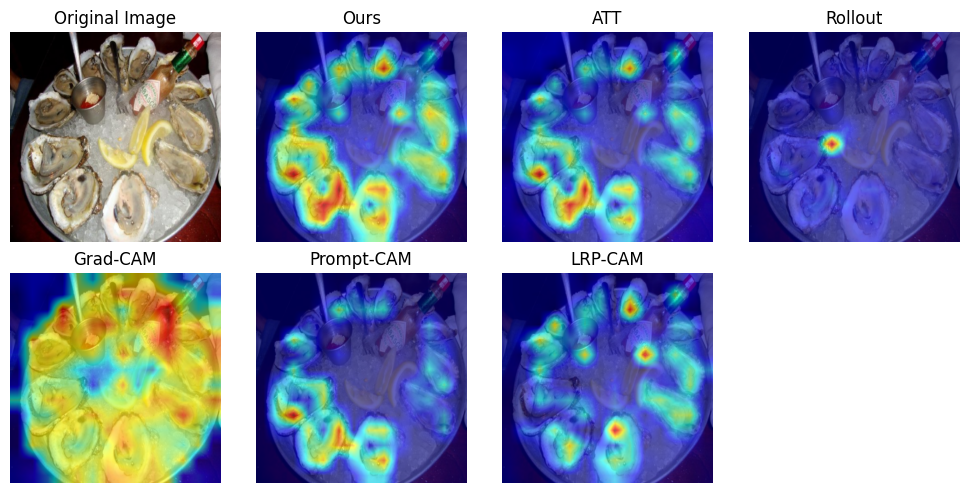

In [3]:
from tools import *
from PIL import Image
import cv2
import numpy as np
import random
import linecache

def random_line_optimized(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)
    if total_lines == 0:
        return None
    random_line_num = random.randint(1, total_lines)
    return linecache.getline(filename, random_line_num).strip()

# def random_line_startswith(filename, prefix):
#     selected_line = None
#     match_count = 0
#     with open(filename, 'r', encoding='utf-8') as f:
#         for line in f:
#             # 检查行是否以特定字符串开头
#             if line.startswith(prefix):
#                 match_count += 1
#                 if random.randint(1, match_count) == 1:
#                     selected_line = line.strip()

#     return selected_line
    
random_path = random_line_optimized('test.txt')

dataset= 'food-101'
size = (1024, 1024) # resolution

# to test a specific image
path = './samples/1102160.jpg'

# to test a random image (requires food-101 dataset)
#path = '../dataset/food-101/images/'+random_path+'.jpg'

target_classes = None # None or class <- choose your target class to visualize a specific attribute

print(f"path: {path}")

# Data preprocess
img = Image.open(path).convert('RGB')
image_tensor = preprocess(img)
image_numpy = cv2.resize(
    np.array(img), 
    size, 
    interpolation=cv2.INTER_LINEAR
)
#image_numpy = np.array(img)
image_tensor = image_tensor.unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    output = model(image_tensor)
if target_classes == None:
    target_classes = torch.argmax(output,dim = 1)
else:
    target_classes = torch.tensor([target_classes], device=device)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_cat_id = torch.topk(probabilities, 5)
with open(f'{dataset}.txt', 'r', encoding='utf-8') as f:
    idx_to_label = [line.strip() for line in f.readlines()]
for i in range(top5_prob.size(0)):
    idx = top5_cat_id[i].item()
    class_name = idx_to_label[idx]
    probability = top5_prob[i].item()
    print(f"Rank {i+1}: {class_name} ({idx}) | Probability: {probability:.4f}")

# Visualize

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5),dpi=100)

plt.subplot(2, 4, 1)
plt.imshow(image_numpy)
plt.title("Original Image")
plt.axis('off')

#cv2.imwrite('./experiment/0/original.jpg',cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR))

saliency_maps = gwaa_cam(model=model, image_tensor=image_tensor, target_classes=target_classes) # B, 1, 224, 224
overlay = apply_colormap_and_overlay(saliency_map=saliency_maps[0,0,:,:].cpu().numpy(), image_numpy=image_numpy)
#cv2.imwrite('./experiment/0/gwaa_cam.jpg',cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
plt.subplot(2, 4, 2)
plt.imshow(overlay)
plt.title("Ours")
plt.axis('off')

saliency_maps = att_cam(model=model, image_tensor=image_tensor, target_classes=target_classes)
overlay = apply_colormap_and_overlay(saliency_map=saliency_maps[0,0,:,:].cpu().numpy(), image_numpy=image_numpy)
#cv2.imwrite('./experiment/0/att_cam.jpg',cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
plt.subplot(2, 4, 3)
plt.imshow(overlay)
plt.title("ATT")
plt.axis('off')

saliency_maps = rollout_cam(model=model, image_tensor=image_tensor, target_classes=target_classes)
overlay = apply_colormap_and_overlay(saliency_map=saliency_maps[0,0,:,:].cpu().numpy(), image_numpy=image_numpy)
#cv2.imwrite('./experiment/0/rollout_cam.jpg',cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
plt.subplot(2, 4, 4)
plt.imshow(overlay)
plt.title("Rollout")
plt.axis('off')

saliency_maps = grad_cam(model=model, image_tensor=image_tensor, target_classes=target_classes)
overlay = apply_colormap_and_overlay(saliency_map=saliency_maps[0,0,:,:].cpu().numpy(), image_numpy=image_numpy)
#cv2.imwrite('./experiment/0/grad_cam.jpg',cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
plt.subplot(2, 4, 5)
plt.imshow(overlay)
plt.title("Grad-CAM")
plt.axis('off')

saliency_maps = prompt_cam(model=model, image_tensor=image_tensor, target_classes=target_classes)
overlay = apply_colormap_and_overlay(saliency_map=saliency_maps[0,0,:,:].cpu().numpy(), image_numpy=image_numpy)
#cv2.imwrite('./experiment/0/prompt_cam.jpg',cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
plt.subplot(2, 4, 6)
plt.imshow(overlay)
plt.title("Prompt-CAM")
plt.axis('off')

saliency_maps = lrp_cam(model=model, image_tensor=image_tensor, target_classes=target_classes)
overlay = apply_colormap_and_overlay(saliency_map=saliency_maps[0,0,:,:].cpu().numpy(), image_numpy=image_numpy)
#cv2.imwrite('./experiment/0/lrp_cam.jpg',cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
plt.subplot(2, 4, 7)
plt.imshow(overlay)
plt.title("LRP-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()
